In [1]:
import json
import csv

import numpy as np
import matplotlib.pyplot as plt
import torch
import copy

import sys
sys.path.append("../../")

import implicitmodules.torch as dm

In [2]:

torch.set_default_dtype(torch.float64)

In [3]:
path_datafiles = '/home/gris/Data/2DShapes/'
path_names = path_datafiles + 'NamesPLAINTEXT/'

names = []
with open(path_names + 'labels.txt', 'r') as namelist:
    for line in namelist:
        names.append(line[:-1])

In [4]:
ind_shape = 14

names_subj = []
with open(path_names + 'ShapeNames/' + names[ind_shape] + '.txt', 'r') as namelist:
    for line in namelist:
        names_subj.append(line[:-1])


In [5]:
ind_subj = 0
path_subj = path_datafiles + 'ShapesJSON/Shapes/' + names_subj[ind_subj] + '.json'
#subj = 

In [6]:
list_subj = []
list_indi_tri = []
list_majo = []
for ind_subj in range(len(names_subj)):
    path_subj = path_datafiles + 'ShapesJSON/Shapes/' + names_subj[ind_subj] + '.json'
    with open(path_subj) as f:
        subj_dict = json.load(f)
        Npts = len(subj_dict['points'])
        subj = []
        for i in range(Npts-1):
            subj.append([subj_dict['points'][i]['x'], subj_dict['points'][i]['y']])

        list_subj.append(np.array(subj))
        
        indi_tri = []
        Ntri = len(subj_dict['triangles'])
        for i in range(Ntri):
            indi_tri.append([subj_dict['triangles'][i]['p1'],subj_dict['triangles'][i]['p2'],subj_dict['triangles'][i]['p3']])
        list_indi_tri.append(np.array(indi_tri))
     
    path_majo = path_datafiles + 'MajorityJSON/Majority/' + names_subj[ind_subj] + '.json'
    with open(path_majo) as f:
        list_majo.append(json.load(f))



In [7]:
ind_subj = 1
subj = list_subj[ind_subj]
indi_tri = list_indi_tri[ind_subj]
majo_dict = list_majo[ind_subj]

(-0.05, 1.05, -0.011699000000000001, 0.24567899999999998)

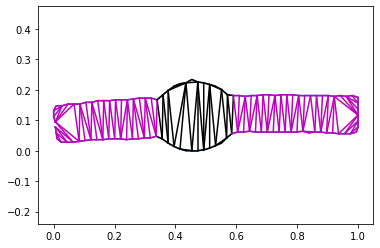

In [8]:
col = ['k', 'm', 'g']
plt.plot(subj[:,0], subj[:,1])
for i in range(np.shape(indi_tri)[0]):
    plt.plot(subj[indi_tri[i],0], subj[indi_tri[i],1], col[majo_dict['majority'][i]])
    t1 = plt.Polygon(subj[indi_tri[i],:], color=col[majo_dict['majority'][i]])
    #plt.gca().add_patch(t1)
plt.axis('equal')

(-0.05, 1.05, -0.015373000000000001, 0.32283300000000004)

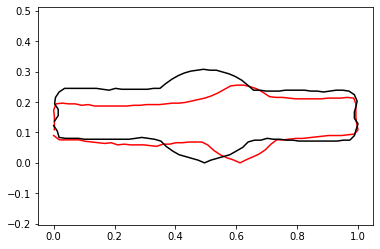

In [43]:
ind_subj_source = 0
subj = list_subj[ind_subj_source]
indi_tri = list_indi_tri[ind_subj_source]
majo_dict = list_majo[ind_subj_source]
plt.plot(subj[:,0], subj[:,1], '-r')

ind_subj_target = 3
subj = list_subj[ind_subj_target]
indi_tri = list_indi_tri[ind_subj_target]
majo_dict = list_majo[ind_subj_target]
plt.plot(subj[:,0], subj[:,1],'k')

plt.axis('equal')

In [44]:
source = torch.tensor(list_subj[ind_subj_source])
target = torch.tensor(list_subj[ind_subj_target])

# Matching with LDDMM

In [12]:
source_deformable = dm.Models.DeformablePoints(source)
target_deformable = dm.Models.DeformablePoints(target)

In [13]:
sigma = 0.05
translations = dm.DeformationModules.ImplicitModule0(2, source.shape[0], sigma, nu=0.1, gd=source.clone().requires_grad_())

In [14]:
sigmas_varifold = [0.1]
attachment = dm.Attachment.VarifoldAttachment(2, sigmas_varifold)

In [15]:
# model = dm.Models.RegistrationModel([source_deformable], [rotation], [dm.Attachment.GeomlossAttachment(loss='sinkhorn', blur=0.05, scaling=0.9)], fit_gd=[True], lam=100.)
model = dm.Models.RegistrationModel([source_deformable], [translations], [attachment], fit_gd=[False], lam=100.)

In [16]:
shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(model, optimizer='torch_lbfgs')
# fitter = dm.Models.Fitter(model, optimizer='scipy_l-bfgs-b')
fitter.fit([target_deformable], 20, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})


Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(4.3638)}
Time: 4.0727315660001295
Iteration: 0
Costs
deformation=0.0022633596522433665
attach=0.012998057975388555
Total cost=0.015261417627631921
Time: 8.064052144000016
Iteration: 1
Costs
deformation=0.0018724445665854574
attach=0.004133671223560675
Total cost=0.006006115790146133
Time: 11.939413564000006
Iteration: 2
Costs
deformation=0.0008687359330444141
attach=0.002639783735469692
Total cost=0.003508519668514106
Time: 15.958170715000051
Iteration: 3
Costs
deformation=0.0003939233098549003
attach=0.001458914361052166
Total cost=0.0018528376709070664
Time: 19.877157254000167
Iteration: 4
Costs
deformation=0.00024356978624664425
attach=0.0011073040981246507
Total cost=0.001350873884371295
Time: 23.939554883000028
Iteration: 5
Costs
deformation=0.0002090182272333635
attach=0.0008562873410333793
Total cost=0.0010653055682667428
Time: 28.0122304370002
Iteration: 6
Costs
deformation=0

In [17]:
intermediates = {}
with torch.autograd.no_grad():
    deformed_source = model.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)[0][0]


(-0.050765977139587894,
 1.050213642130256,
 -0.013618641407798391,
 0.270714221019419)

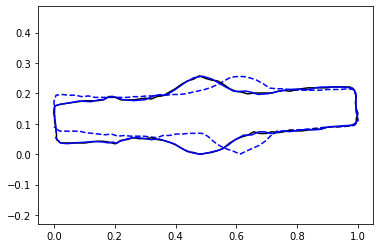

In [18]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
plt.plot(deformed_source.detach().numpy()[:,0], deformed_source.detach().numpy()[:,1], 'b')
plt.axis('equal')

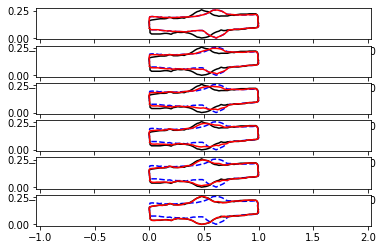

In [19]:
for i in range(6):
    plt.subplot(6,1,i+1)
    plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
    plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
    plt.plot(intermediates['states'][2*i].gd[1].detach().numpy()[:,0], intermediates['states'][2*i].gd[1].detach().numpy()[:,1], 'r')
    plt.axis('equal')

# Matching with growth model

In [45]:
aabb = dm.Utilities.aabb.AABB.build_from_points(source)

In [46]:
aabb.scale_([1.5, 2])

In [47]:
aabb_source = dm.Utilities.AABB.build_from_points(source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=source)


(-0.05, 1.05, -0.012766, 0.268086)

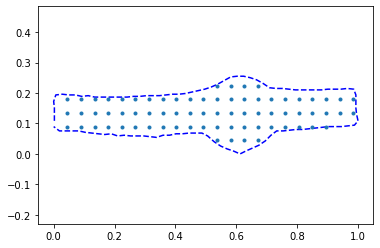

In [48]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(points_growth[:,0], points_growth[:,1], '.')
plt.axis('equal')

In [49]:
indi_left0 = range(0, 28)
indi_left1 = range(80, 104)
indi_right = range(37, 69)

part_left = np.concatenate([source[indi_left1, :], source[indi_left0, :]], axis = 0)
part_right = source[indi_right, :]

(-0.05, 1.05, -0.012766, 0.268086)

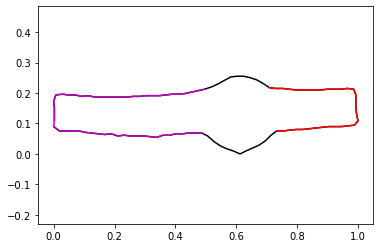

In [50]:
plt.plot(source[:,0], source[:,1], 'k')
plt.plot(part_left[:,0], part_left[:,1], 'm')
plt.plot(part_right[:,0], part_right[:,1], 'r')
plt.axis('equal')

In [51]:
aabb_source = dm.Utilities.AABB.build_from_points(source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=source)
points_growthleft = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=torch.tensor(part_left), intersect=True)
points_growthright = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=torch.tensor(part_right), intersect=True)


/home/gris/penv36/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [52]:
indi_growth_left = range(0,points_growthleft.shape[0] +2)
indi_growth_right = range(points_growth.shape[0]-points_growthright.shape[0], points_growth.shape[0])
indi_growth_main = range(points_growthleft.shape[0] +2,points_growth.shape[0]-points_growthright.shape[0])

(-0.05, 1.05, -0.012766, 0.268086)

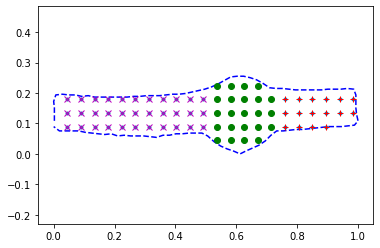

In [53]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(points_growth[:,0], points_growth[:,1], '.')
plt.plot(points_growth[indi_growth_left,0], points_growth[indi_growth_left,1], 'xm')
plt.plot(points_growth[indi_growth_right,0], points_growth[indi_growth_right,1], '+r')
plt.plot(points_growth[indi_growth_main,0], points_growth[indi_growth_main,1], 'og')
plt.axis('equal')

In [54]:
#%matplotlib qt5
C = torch.zeros(points_growth.shape[0], 2, 5)
C[indi_growth_left, 0, 0] = 1.
C[indi_growth_right, 0, 1] = 1.
C[indi_growth_left, 1, 2] = 1.
C[indi_growth_right, 1, 3] = 1.
C[indi_growth_main, 0, 4] = 1.
C[indi_growth_main, 1, 4] = 1.

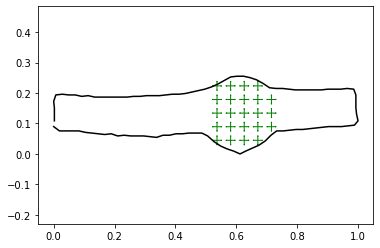

In [55]:
ax = plt.subplot()
dm.Utilities.plot_C_arrows(ax, points_growth, C, c_index=4, color='green', scale=0.05)
plt.plot(source[:, 0].numpy(), source[:, 1].numpy(), color='black')
plt.axis('equal')
plt.show()

In [56]:
rot_growth = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)
scale_growth = 0.1
coeff_growth = 1.
nu = 0.001
growth = dm.DeformationModules.ImplicitModule1(
    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, coeffcont=100., nu=nu,
    gd=(points_growth, rot_growth))

In [57]:
rotation = dm.DeformationModules.LocalRotation(2, 1., gd=torch.tensor([[0., 0.]]).requires_grad_())

In [58]:
global_translation = dm.DeformationModules.GlobalTranslation(2)

In [59]:
source_deformable = dm.Models.DeformablePoints(source)
target_deformable = dm.Models.DeformablePoints(target)

In [60]:
sigmas_varifold = [0.1]
attachment = dm.Attachment.VarifoldAttachment(2, sigmas_varifold)

In [62]:
modelgrowth = dm.Models.RegistrationModel([source_deformable], [global_translation, rotation, growth], [attachment], fit_gd=[False], lam=10.)

In [63]:
shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(modelgrowth, optimizer='torch_lbfgs')
# fitter = dm.Models.Fitter(model, optimizer='scipy_l-bfgs-b')
fitter.fit([target_deformable], 20, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})


Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(0.8481)}
Time: 76.42139329099882
Iteration: 0
Costs
deformation=0.0016053521595540696
attach=0.645408278365367
Total cost=0.647013630524921
Time: 139.26202876400203
Iteration: 1
Costs
deformation=0.011600648059339594
attach=0.6208433184877205
Total cost=0.63244396654706
Time: 247.78441168800055
Iteration: 2
Costs
deformation=0.03285884969305817
attach=0.5526249161330687
Total cost=0.5854837658261269
Time: 416.6302148210016
Iteration: 3
Costs
deformation=0.09023080699108328
attach=0.48270290284197603
Total cost=0.5729337098330594
Time: 595.6884081310018
Iteration: 4
Costs
deformation=0.05586076184436105
attach=0.35137379360442145
Total cost=0.4072345554487825
Time: 732.7188166480009
Iteration: 5
Costs
deformation=0.08783843140027699
attach=0.2814749021883345
Total cost=0.36931333358861146
Time: 800.654227340001
Iteration: 6
Costs
deformation=0.0038860755240793543
attach=0.272802865667

In [64]:
intermediates = {}
with torch.autograd.no_grad():
    deformed_source = modelgrowth.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)[0][0]


(-0.0579707390154548,
 1.0503795590007359,
 -0.027187709257378193,
 0.3233956052027323)

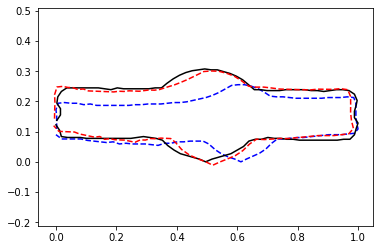

In [65]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
plt.plot(deformed_source.detach().numpy()[:,0], deformed_source.detach().numpy()[:,1], '--r')
plt.axis('equal')

tensor([-0.0914,  0.2015,  0.2296,  0.2577,  0.2289])
tensor([-0.1578,  0.2112,  0.2088,  0.2388,  0.2062])
tensor([-0.2362,  0.2071,  0.1877,  0.2145,  0.1842])
tensor([-0.3304,  0.1862,  0.1651,  0.1871,  0.1608])
tensor([-0.3880,  0.1571,  0.1382,  0.1520,  0.1293])


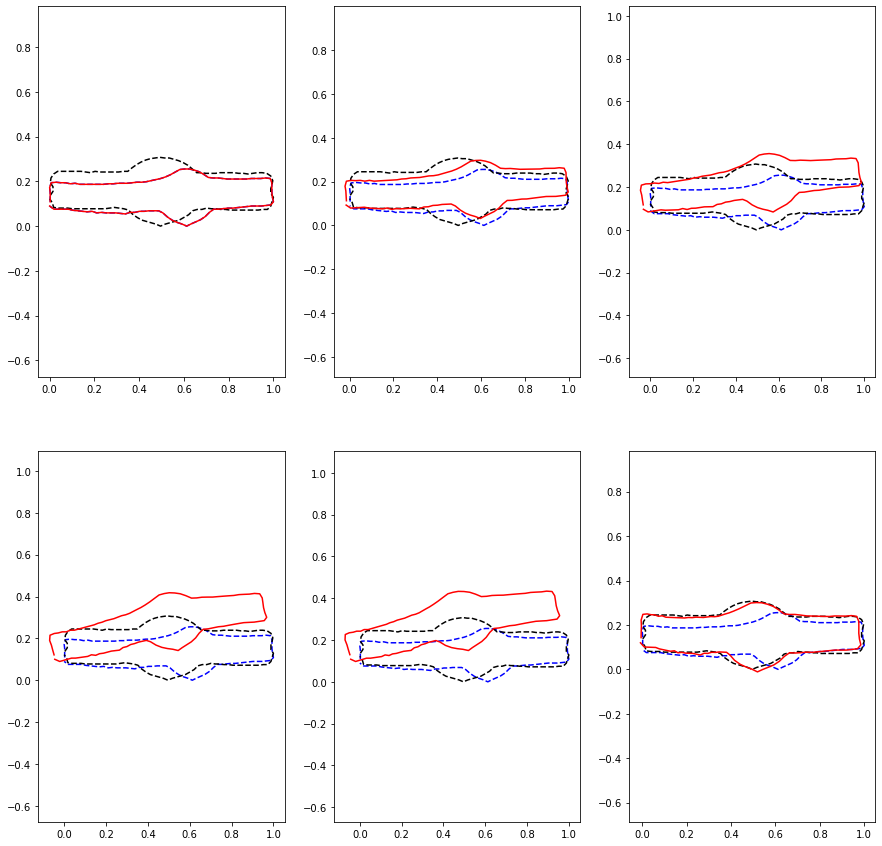

In [66]:
f = plt.figure(figsize=(15,15))
for i in range(6):
    ax = f.add_subplot(2,3,i+1)
    if i<5:
        print(intermediates['controls'][2*i][3])
    plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
    plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], '--k')
    plt.plot(intermediates['states'][2*i].gd[0].detach().numpy()[:,0], intermediates['states'][2*i].gd[0].detach().numpy()[:,1], 'r')
    plt.axis('equal')

In [68]:
sum([intermediates['controls'][i][3] for i in range(10)])

tensor([-2.5564,  1.8972,  1.8020,  2.0274,  1.7529])

In [67]:
for i in range(10):
    print(intermediates['controls'][i][2])

tensor(0.5392)
tensor(0.7532)
tensor(0.9620)
tensor(1.1475)
tensor(1.2572)
tensor(1.1834)
tensor(0.7416)
tensor(-0.3301)
tensor(-2.2372)
tensor(-4.6708)


In [82]:
# We extract the modules of the models and fill the right manifolds.
silent = dm.DeformationModules.SilentBase(copy.copy(modelgrowth.init_manifold.clone().manifolds[0]), label='sil')
modules = dm.DeformationModules.CompoundModule([silent] + copy.copy(modelgrowth.modules))
modules.manifold.fill(modelgrowth.init_manifold.clone(), copy=True)
deformation_grid = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(silent.manifold.gd).scale(1.2).squared(), [64, 64])
#translation = copy.copy(modelgrowth.modules[0])
#growth2 = copy.copy(modelgrowth.modules[1])

In [83]:
CompoundModule = dm.DeformationModules.CompoundModule([deformation_grid] + modules.modules)

In [84]:
# We construct the controls list we will give will shooting
controls = [[torch.tensor([]), torch.tensor([]), 0.*control[1], 0.*control[2], torch.tensor([0.*control[3][0], 0.*control[3][1], 1.*control[3][2], 0.*control[3][3], 0.*control[3][4]])] for control in intermediates['controls']]

In [85]:
intermediates_cont = {}
dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian(CompoundModule.modules), shoot_solver, shoot_it, controls=controls, intermediates=intermediates_cont)

In [86]:
growth_deformed_source = silent.manifold.gd.detach()
growth_deformed_grid = deformation_grid.togrid()

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(-0.)


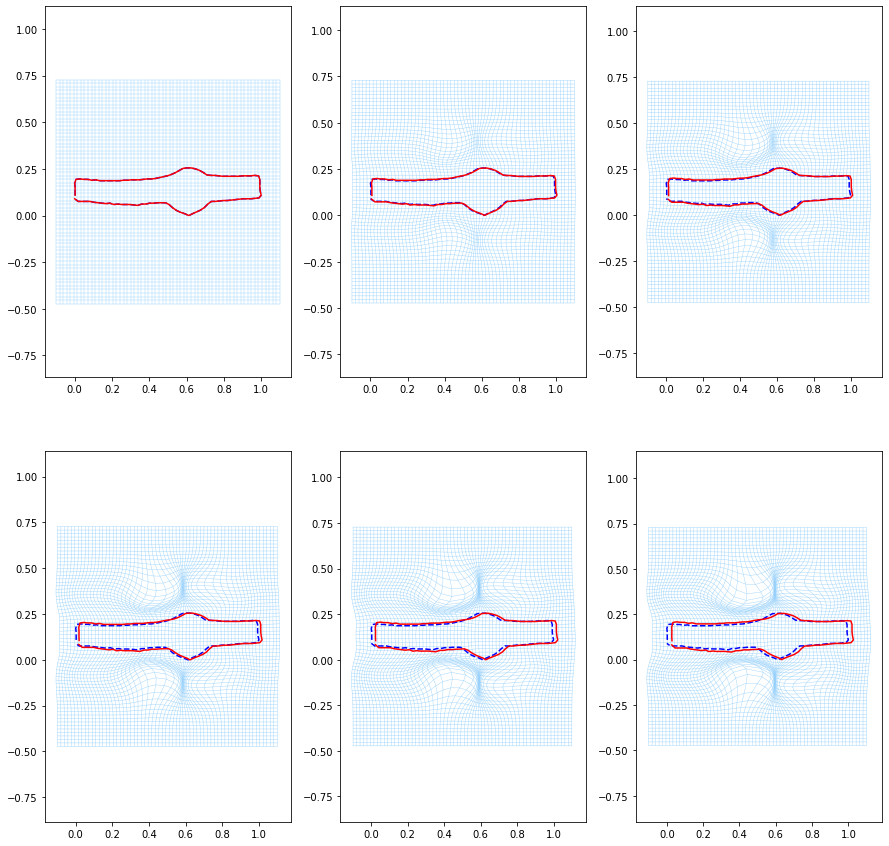

In [87]:
f = plt.figure(figsize=(15,15))
for i in range(6):
    ax = f.add_subplot(2,3,i+1)
    if i<5:
        print(intermediates_cont['controls'][2*i][3])
    deformation_grid_t = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(silent.manifold.gd).scale(1.2).squared(), [64, 64])
    deformation_grid_t.manifold.fill_gd(intermediates_cont['states'][2*i].gd[0].detach())
    growth_deformed_grid_t = deformation_grid_t.togrid()
    dm.Utilities.plot_grid(ax, growth_deformed_grid_t[0], growth_deformed_grid_t[1], color='xkcd:light blue', lw=0.4)
    plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
    #plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], '--k')
    plt.plot(intermediates_cont['states'][2*i].gd[1].detach().numpy()[:,0], intermediates_cont['states'][2*i].gd[1].detach().numpy()[:,1], 'r')
    plt.axis('equal')

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(-0.)


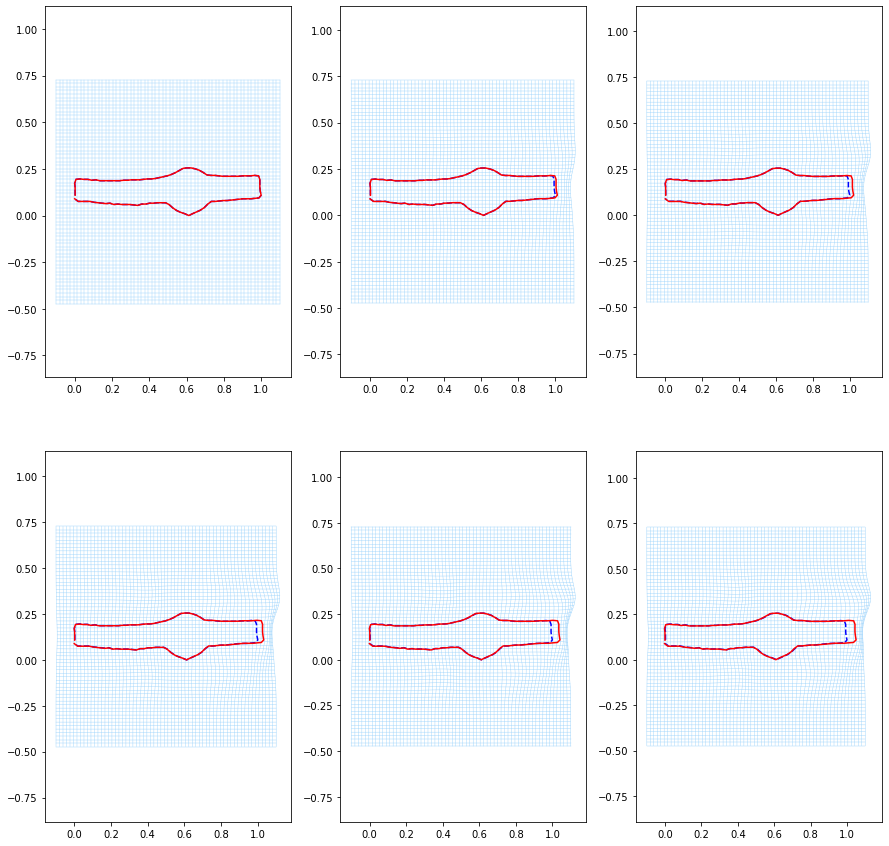

In [81]:
f = plt.figure(figsize=(15,15))
for i in range(6):
    ax = f.add_subplot(2,3,i+1)
    if i<5:
        print(intermediates_cont['controls'][2*i][3])
    deformation_grid_t = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(silent.manifold.gd).scale(1.2).squared(), [64, 64])
    deformation_grid_t.manifold.fill_gd(intermediates_cont['states'][2*i].gd[0].detach())
    growth_deformed_grid_t = deformation_grid_t.togrid()
    dm.Utilities.plot_grid(ax, growth_deformed_grid_t[0], growth_deformed_grid_t[1], color='xkcd:light blue', lw=0.4)
    plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
    #plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], '--k')
    plt.plot(intermediates_cont['states'][2*i].gd[1].detach().numpy()[:,0], intermediates_cont['states'][2*i].gd[1].detach().numpy()[:,1], 'r')
    plt.axis('equal')

(-0.2099575578392855,
 1.3644548670464338,
 -0.5323633347340097,
 0.7877051311809289)

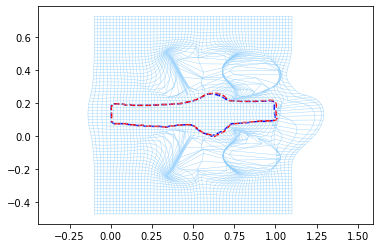

In [75]:
#%matplotlib qt5
ax = plt.subplot(1, 1, 1)
plt.plot(source.detach().numpy()[:, 0], source.detach().numpy()[:, 1], '--b')
#plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
plt.plot(growth_deformed_source[:, 0].numpy(), growth_deformed_source[:, 1].numpy(), '--r')
dm.Utilities.plot_grid(ax, growth_deformed_grid[0], growth_deformed_grid[1], color='xkcd:light blue', lw=0.4)
plt.axis('equal')


# Working on images

In [11]:
source_image = dm.Utilities.load_greyscale_image( path_datafiles + 'Images/watch01.png', origin='lower')
target_image = dm.Utilities.load_greyscale_image( path_datafiles + 'Images/watch03.png', origin='lower')

In [34]:
source_image.shape

torch.Size([202, 500])

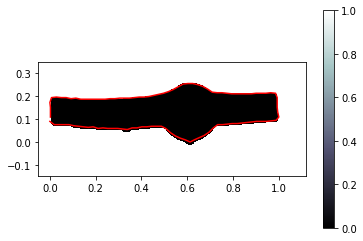

In [12]:

extent_source = dm.Utilities.AABB( -0.05, 1.12,-0.15, 0.35)

plt.imshow(source_image.numpy(), origin='lower', cmap='bone', extent=extent_source.totuple())
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], 'r')
plt.colorbar()

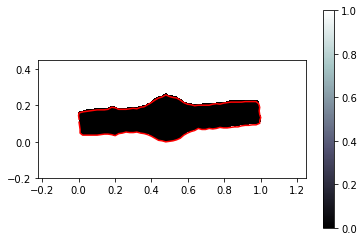

In [13]:
extent_target = dm.Utilities.AABB( -0.22, 1.25,-0.2, 0.45)
target_image = dm.Utilities.load_greyscale_image( path_datafiles + 'Images/watch11.png', origin='lower')
plt.imshow(target_image.numpy(), origin='lower', cmap='bone', extent=extent_target.totuple())
plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'r')
plt.colorbar()

In [14]:
indi_left0 = range(0, 28)
indi_left1 = range(80, 104)
indi_right = range(37, 69)

part_left = np.concatenate([source[indi_left1, :], source[indi_left0, :]], axis = 0)
part_right = source[indi_right, :]

In [15]:
aabb_source = dm.Utilities.AABB.build_from_points(source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=source)
points_growthleft = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=torch.tensor(part_left), intersect=True)
points_growthright = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=torch.tensor(part_right), intersect=True)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [16]:
indi_growth_left = range(0,points_growthleft.shape[0] +2)
indi_growth_right = range(points_growth.shape[0]-points_growthright.shape[0], points_growth.shape[0])

(-0.05, 1.05, -0.012766, 0.268086)

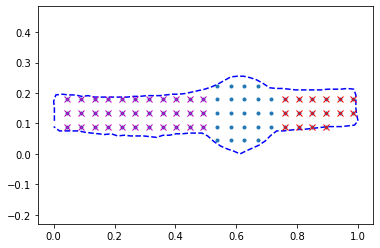

In [17]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(points_growth[:,0], points_growth[:,1], '.')
plt.plot(points_growth[indi_growth_left,0], points_growth[indi_growth_left,1], 'xm')
plt.plot(points_growth[indi_growth_right,0], points_growth[indi_growth_right,1], 'xr')
plt.axis('equal')

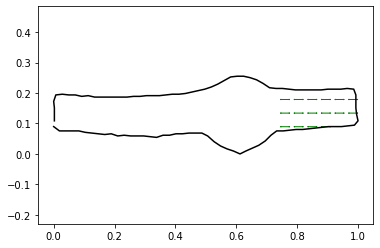

In [18]:
#%matplotlib qt5
C = torch.zeros(points_growth.shape[0], 2, 2)
C[indi_growth_left, 0, 0] = 1.
C[indi_growth_right, 0, 1] = 1.

ax = plt.subplot()
dm.Utilities.plot_C_arrows(ax, points_growth, C, c_index=1, color='green', scale=0.05)
plt.plot(source[:, 0].numpy(), source[:, 1].numpy(), color='black')
plt.axis('equal')
plt.show()


In [19]:
rot_growth = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)
scale_growth = 0.1
coeff_growth = 1.
nu = 0.001
growth = dm.DeformationModules.ImplicitModule1(
    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, nu=nu,
    gd=(points_growth, rot_growth))

In [20]:
global_translation = dm.DeformationModules.GlobalTranslation(2)

In [21]:
source_deformable = dm.Models.DeformableImage(source_image, output='bitmap',
                                              extent=extent_source)
target_deformable = dm.Models.DeformableImage(target_image, output='bitmap',
                                              extent=extent_target)

In [22]:

source_image_deformable = dm.Models.DeformableImage(source_image, output='bitmap',
                                              extent=extent_source)
target_image_deformable = dm.Models.DeformableImage(target_image, output='bitmap',
                                              extent=extent_target)


In [23]:
attachment_image = dm.Attachment.EuclideanPointwiseDistanceAttachment()

In [31]:
target_image_deformable.geometry[0].shape

torch.Size([224, 520])

In [30]:
source_image_deformable.geometry[0].shape

torch.Size([202, 500])

In [26]:
attachment_image(source_image_deformable.geometry, target_image_deformable.geometry)

RuntimeError: The size of tensor a (500) must match the size of tensor b (520) at non-singleton dimension 1

In [81]:
modelgrowth_image = dm.Models.RegistrationModel([source_image_deformable], [global_translation, growth], [attachment_image], fit_gd=[False], lam=100.)

In [83]:
shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(modelgrowth_image, optimizer='torch_lbfgs')
# fitter = dm.Models.Fitter(model, optimizer='scipy_l-bfgs-b')
fitter.fit(target_image_deformable, 20, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

KeyboardInterrupt: 